<a href="https://colab.research.google.com/github/varJATIN/Ocular-fundus-image-Analysis/blob/main/unet_attention_idrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

## Seeding 
seed = 2
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c=tf.keras.layers.BatchNormalization()(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c=tf.keras.layers.BatchNormalization()(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def atten(x,g,F_x,F_g,F_int,kernel_size=(3,3), padding="same", strides=1):
    # upsample lower decoder filters
    us = keras.layers.UpSampling2D((2, 2))(g)
    gate = keras.layers.Conv2D(F_g, kernel_size, padding=padding, strides=strides, activation="relu")(us)
    gate=tf.keras.layers.BatchNormalization()(gate)
    
    # convolve the upsampled decoder filter for F_int filters
    W_g=keras.layers.Conv2D(F_int, kernel_size=1, padding=padding, strides=strides)(gate)
    W_g=tf.keras.layers.BatchNormalization()(W_g)
    
    # convolve encoder output for F_int filters
    W_x=keras.layers.Conv2D(F_int, kernel_size=1, padding=padding, strides=strides)(x)
    W_x=tf.keras.layers.BatchNormalization()(W_x)
    
    # convolve to one attention filter
    psi=tf.keras.activations.relu(W_x+W_g, alpha=0.0, max_value=None, threshold=0)
    psi=keras.layers.Conv2D(1, kernel_size=1, padding=padding, strides=strides)(psi)
    psi=tf.keras.activations.sigmoid(tf.keras.layers.BatchNormalization()(psi))
    
    # return the filtered encoder output for concat
    return x*psi

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    us = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(us)
    us = tf.keras.layers.BatchNormalization()(us)
    # here skip is from encoder and x if from dec previous layer 
    filtered_skip=atten(skip,x,filters,filters,filters/2)
    #concat filtrd skip and upsampled us
    concat = keras.layers.Concatenate()([us, filtered_skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c=tf.keras.layers.BatchNormalization()(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c=tf.keras.layers.BatchNormalization()(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c=tf.keras.layers.BatchNormalization()(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c=tf.keras.layers.BatchNormalization()(c) 
    return c

In [4]:
def UNet():
    #f = [16, 32, 64, 128, 256]
    f = [3, 6, 12, 24, 48]
    
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])#8*8*48
    
    u1 = up_block(bn, c4, f[3]) #8 - > 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [5]:
from sklearn.utils import shuffle
from matplotlib.pyplot import imread
from cv2 import resize
import matplotlib.pyplot as plt
import cv2

## Train data read

In [56]:
# data
data_location = "/content/drive/My Drive/IDRid/A. Segmentation/1. Original Images/a. Training Set"
train_data = []  # create an empty list
for (dirName, subdirList, fileList) in sorted(os.walk(data_location)):
    for fileName in sorted(fileList):
        if ".jpg" in fileName.lower() :
            train_data.append(os.path.join(dirName,fileName))

print(len(train_data))

54


In [7]:

# groundtruths for hard exudates
#target_root_location = "/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/3. Hard Exudates"
data_location = "/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/3. Hard Exudates"
train_data_gt = []  # create an empty list
segs=['1. Microaneurysms','2. Haemorrhages','3. Hard Exudates','4. Soft Exudates']
#for seg in segs:
#  data_location=target_root_location+seg
#  seg_mask=[]
for dirName, subdirList, fileList in sorted(os.walk(data_location)):
    for filename in sorted(fileList):
        if ".tif" in filename.lower() :
            #seg_mask.append(os.path.join(dirName,filename))
            train_data_gt.append(os.path.join(dirName,filename))
#train_data_gt.append(seg_mask)
print(len(train_data_gt));

54


## Test data read

In [52]:
# data
data_location = "/content/drive/My Drive/IDRid/A. Segmentation/1. Original Images/b. Testing Set"
test_data = []  # create an empty list
for (dirName, subdirList, fileList) in sorted(os.walk(data_location)):
    for fileName in sorted(fileList):
        if ".jpg" in fileName.lower() :
            test_data.append(os.path.join(dirName,fileName))

In [53]:
data_location = "/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/3. Hard Exudates"
test_data_gt = []  # create an empty list
for dirName, subdirList, fileList in sorted(os.walk(data_location)):
    for filename in sorted(fileList):
        if ".tif" in filename.lower() :
            test_data_gt.append(os.path.join(dirName,filename))
print(len(test_data_gt));

27


(2848, 4288, 4)


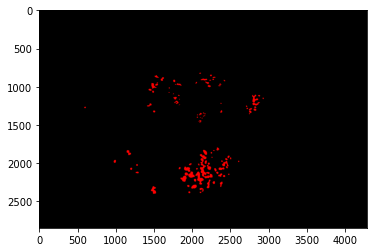

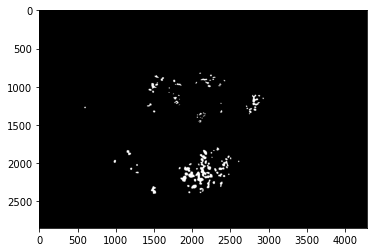

(2848, 4288)


In [8]:
print(imread(train_data_gt[0]).shape)
plt.imshow(imread(train_data_gt[0]),cmap='gray')
plt.show()
img = cv2.cvtColor(imread(train_data_gt[0]), cv2.COLOR_BGRA2BGR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img, cmap = 'gray')
plt.show()
print(img.shape)

In [ ]:
np.max(img),np.min(img),np.max(imread(train_data[0]))

(29, 0, 255)

## Train data

In [58]:
train_batch = np.zeros(shape = (len(train_data)*3, 512, 512, 3));
train_labels_ls=[]
train_label = np.zeros(shape = (len(train_data)*3, 512, 512, 1));

for file_index in range(0,len(train_data)*3,3):
    #print(file_index)
    # image
    train_batch[file_index, :, :,:] = resize(imread(train_data[int(file_index/3)]), (512, 512))
    # label
    img = cv2.cvtColor(imread(train_data_gt[int(file_index/3)]), cv2.COLOR_BGRA2BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    train_label[file_index, :, :,:] = np.expand_dims(resize(img, (512, 512)), axis = 2)
    #flip
    train_batch[file_index+1, :, :,:]=np.flip(train_batch[file_index, :, :,:],axis=1)
    train_label[file_index+1, :, :,:]=np.flip(train_label[file_index, :, :,:],axis=1)
    #rotate
    train_batch[file_index+2, :, :,:]=np.rot90(np.rot90(train_batch[file_index, :, :,:]))
    train_label[file_index+2, :, :,:]=np.rot90(np.rot90(train_label[file_index, :, :,:]))


train_batch[:,:,:,0]  = (train_batch[:,:,:,0])/255# - train_images[:,:,:,0].min(axis=0)) / (train_images[:,:,:,0].max(axis=0) - train_images[:,:,:,0].min(axis=0)+1e-10)
train_batch[:,:,:,1]  = (train_batch[:,:,:,1])/255# - train_images[:,:,:,1].min(axis=0)) / (train_images[:,:,:,1].max(axis=0) - train_images[:,:,:,1].min(axis=0)+1e-10)
train_batch[:,:,:,2]  = (train_batch[:,:,:,2])/255# - train_images[:,:,:,2].min(axis=0)) / (train_images[:,:,:,2].max(axis=0) - train_images[:,:,:,2].min(axis=0)+1e-10)

train_label[:,:,:,0]  = (train_label[:,:,:,0] - train_label[:,:,:,0].min(axis=0)) / (train_label[:,:,:,0].max(axis=0) - train_label[:,:,:,0].min(axis=0)+1e-10)
mask = train_label[:,:,:,:] > 0.3
train_label[mask] = 1.0
train_label[~mask] = 0.0

print(train_batch.shape)
print(train_label.shape)

(162, 512, 512, 3)
(162, 512, 512, 1)


## Test data

In [69]:
test_batch = np.zeros(shape = (len(test_data), 512, 512, 3));
#test_labels_ls=[]
test_label = np.zeros(shape = (len(test_data), 512, 512, 1));

for file_index in range(0,len(test_data)):
    #print(file_index)
    # image
    test_batch[file_index, :, :,:] = resize(imread(test_data[int(file_index)]), (512, 512))
    # label
    img = cv2.cvtColor(imread(test_data_gt[int(file_index)]), cv2.COLOR_BGRA2BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    test_label[file_index, :, :,:] = np.expand_dims(resize(img, (512, 512)), axis = 2)

test_batch  = test_batch/255

test_label[:,:,:,0]  = (test_label[:,:,:,0] - test_label[:,:,:,0].min(axis=0)) / (test_label[:,:,:,0].max(axis=0) - test_label[:,:,:,0].min(axis=0)+1e-10)

mask = test_label[:,:,:,:] > 0.3
test_label[mask] = 1.0
test_label[~mask] = 0.0

print(test_batch.shape)
print(test_label.shape)

(27, 512, 512, 3)
(27, 512, 512, 1)


In [68]:
np.max(test_label),np.min(train_labels),np.max(test_batch)

(1.0, 0.0, 0.0)

In [ ]:
for i in range(6):
  plt.imshow(train_images[i])
  plt.show()
  plt.imshow(np.squeeze(train_labels[i]), cmap = 'gray')
  plt.show()

In [40]:
from keras import backend as K
def dice_loss(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return 1-dice

In [59]:
seed = 2
random.seed = seed
np.random.seed = seed
tf.seed = seed
tf.random.set_seed(2)
image_size = 512
epochs = 100
batch_size = 2

"""
learning_rates = []
models = []
history = []
rate = 1
while(len(learning_rates) < 15) :
    learning_rates.append(rate);
    if rate > 0.000001:
        rate /= 10;
    else:
         rate /= 5;
print(learning_rates)

"""
#for rate in learning_rates :
rate=0.001
opt=keras.optimizers.Adam(learning_rate = rate)
model = UNet()
model.compile(optimizer=opt, loss=dice_loss, metrics=[tf.keras.metrics.AUC()])  
# model.summary()
#print("rate = {}".format(rate))
callback= tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta	=0.001, patience=5)
hist = model.fit(x = train_batch, y = train_label, batch_size = 2, epochs = 100, verbose = 1, callbacks=[callback], validation_split = 8/50, shuffle = True)
#models.append(model)
#history.append(hist)


Epoch 1/100
68/68 [==============================] - 9s 131ms/step - loss: 0.9722 - auc_6: 0.7682 - val_loss: 0.9853 - val_auc_6: 0.7278
Epoch 2/100
68/68 [==============================] - 7s 107ms/step - loss: 0.9608 - auc_6: 0.8204 - val_loss: 0.9867 - val_auc_6: 0.6748
Epoch 3/100
68/68 [==============================] - 7s 107ms/step - loss: 0.9479 - auc_6: 0.7952 - val_loss: 0.9722 - val_auc_6: 0.5569
Epoch 4/100
68/68 [==============================] - 7s 106ms/step - loss: 0.9356 - auc_6: 0.7084 - val_loss: 0.9854 - val_auc_6: 0.5964
Epoch 5/100
68/68 [==============================] - 7s 106ms/step - loss: 0.9166 - auc_6: 0.7116 - val_loss: 0.9710 - val_auc_6: 0.5857
Epoch 6/100
68/68 [==============================] - 7s 107ms/step - loss: 0.8906 - auc_6: 0.6920 - val_loss: 0.9137 - val_auc_6: 0.6799
Epoch 7/100
68/68 [==============================] - 7s 106ms/step - loss: 0.8877 - auc_6: 0.6739 - val_loss: 0.9687 - val_auc_6: 0.6534
Epoch 8/100
68/68 [======================

In [ ]:
for hist in history:
    plt.plot(hist.history['loss'])

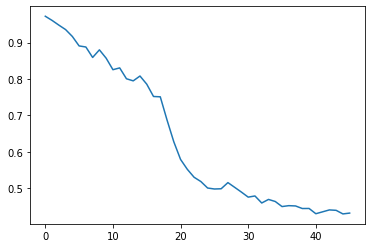

In [60]:
plt.plot(hist.history['loss'])

(512, 512, 1)


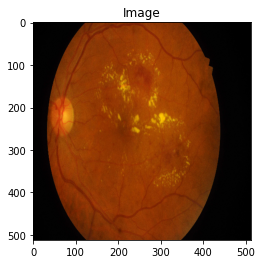

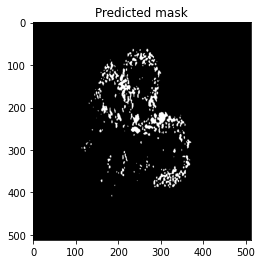

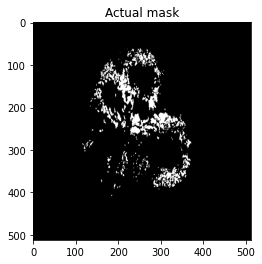

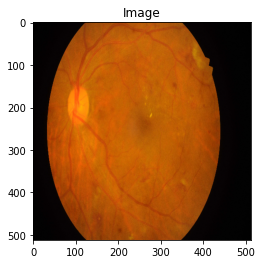

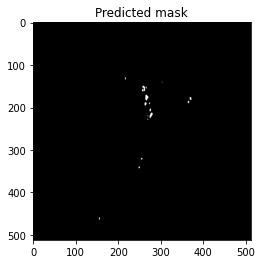

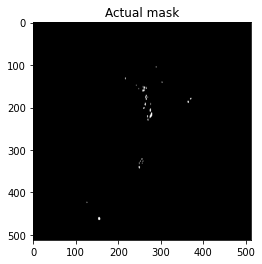

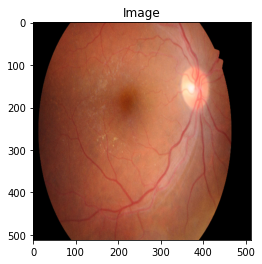

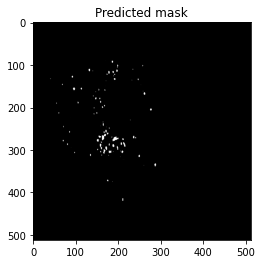

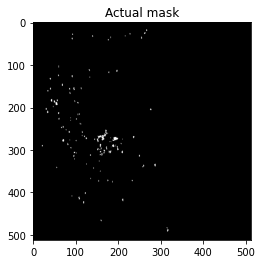

In [83]:
#for model in models:
predicted_test_label=model.predict(test_batch)
print(predicted_test_label[0].shape)
for i in range(3):
    plt.imshow(test_batch[i,:,:,:])
    plt.title("Image")
    plt.show()  
    plt.imshow(np.squeeze(predicted_test_label[i,:,:,:], axis = 2),cmap='gray')
    plt.title("Predicted mask")
    plt.show()
    plt.imshow(np.squeeze(test_label[i,:,:,:], axis = 2), cmap='gray')
    plt.title("Actual mask")
    plt.show()

(512, 512, 1)


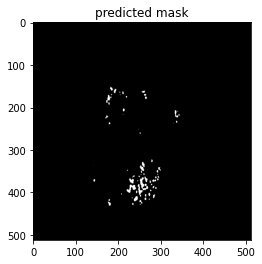

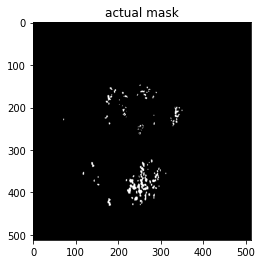

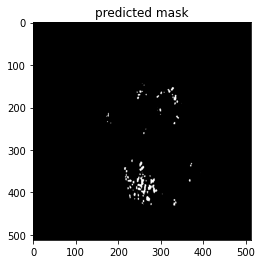

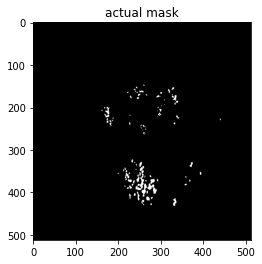

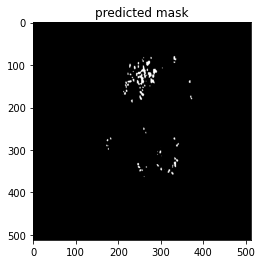

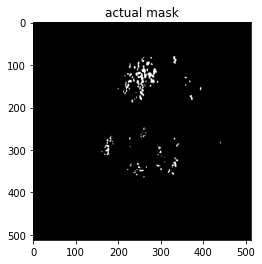

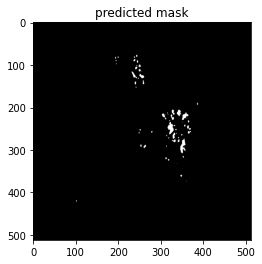

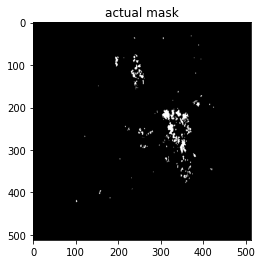

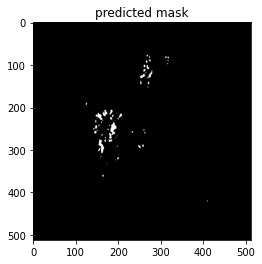

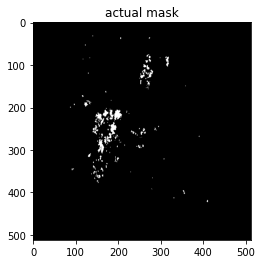

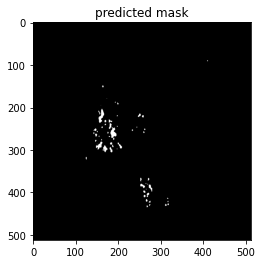

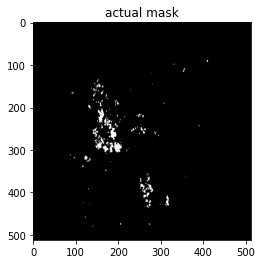

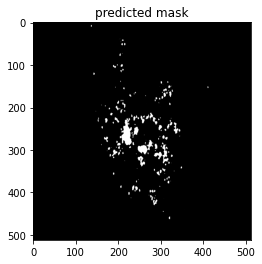

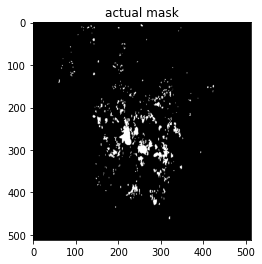

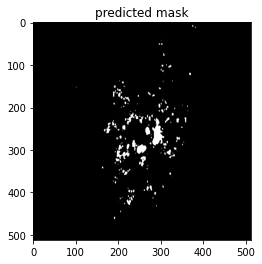

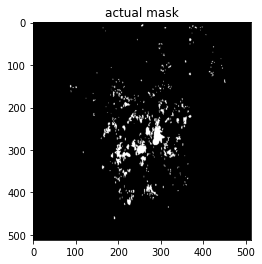

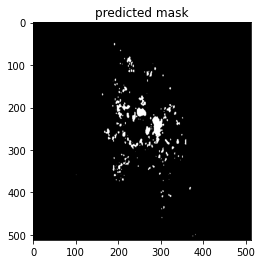

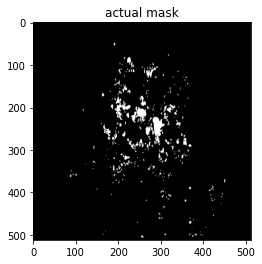

In [62]:
predicted_train_label = model.predict(train_batch);
print(predicted_train_label[0].shape)
for i in range(9):
    #print("Predicted")
    plt.imshow(np.squeeze(predicted_train_label[i,:,:,:],axis=2),cmap='gray')
    plt.title("predicted mask")
    plt.show()
    plt.imshow(np.squeeze(train_label[i,:,:,:],axis=2),cmap='gray')
    plt.title("actual mask")
    plt.show()

In [71]:
from sklearn.metrics import roc_auc_score
test_auc = roc_auc_score(test_label.reshape(-1),predicted_test_label.reshape(-1))
train_auc = roc_auc_score(train_label.reshape(-1),predicted_train_label.reshape(-1))
print("train ",train_auc," test ",test_auc)

train  0.7367131741526264  test  0.7237046591846584


In [72]:
from sklearn.metrics import f1_score
testy, yhat_classes=(test_label.reshape(-1),np.round(predicted_test_label.reshape(-1)))
test_f1 = f1_score(testy, yhat_classes)
testy, yhat_classes=train_label.reshape(-1),np.round(predicted_train_label.reshape(-1))
train_f1 = f1_score(testy, yhat_classes)
print('Train  F1 score: %f' % train_f1,'Test F1 score: %f' % test_f1)

Train  F1 score: 0.652888 Test F1 score: 0.648989


In [82]:
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
test_aupr = precision_recall_curve(test_label.reshape(-1),predicted_test_label.reshape(-1))
train_aupr = precision_recall_curve(train_label.reshape(-1),predicted_train_label.reshape(-1))
train_auc=auc(train_aupr[1],train_aupr[0] )
test_auc=auc(test_aupr[1],test_aupr[0] )
print("train AUC",train_auc," test AUC",test_auc)

train AUC 0.5782916035989822  test AUC 0.5783894765532598


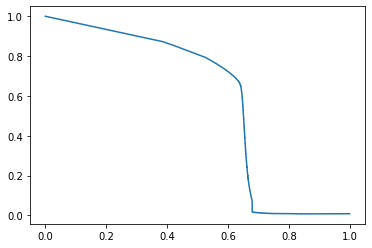

In [81]:
plt.plot(train_aupr[1],train_aupr[0])
plt.show()

In [73]:
#serialize and save model 
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
